In [1]:
import ingestor, modeller, fitter, viewer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)
reload(viewer)

<module 'viewer' from '/media/dwu402/Data/wrap-mad/viewer.py'>

In [ ]:
context = ingestor.Context("runs/quad_recovery.3.3.run")

In [ ]:
solver = fitter.Fitter(context)

In [ ]:
rhos = np.logspace(-6, 6, num=49)
for rhoi in rhos:
    solver.solve(rhoi)
    for i, p in enumerate(solver.problems):
        p.initial_guess = solver.solutions[str(rhoi)][i].x

In [18]:
viewer.setup_canvas(size=True, ipy=True)
view = viewer.Plotter(context=context, fitter=solver)
plabels = "arkpmscdfgjl"

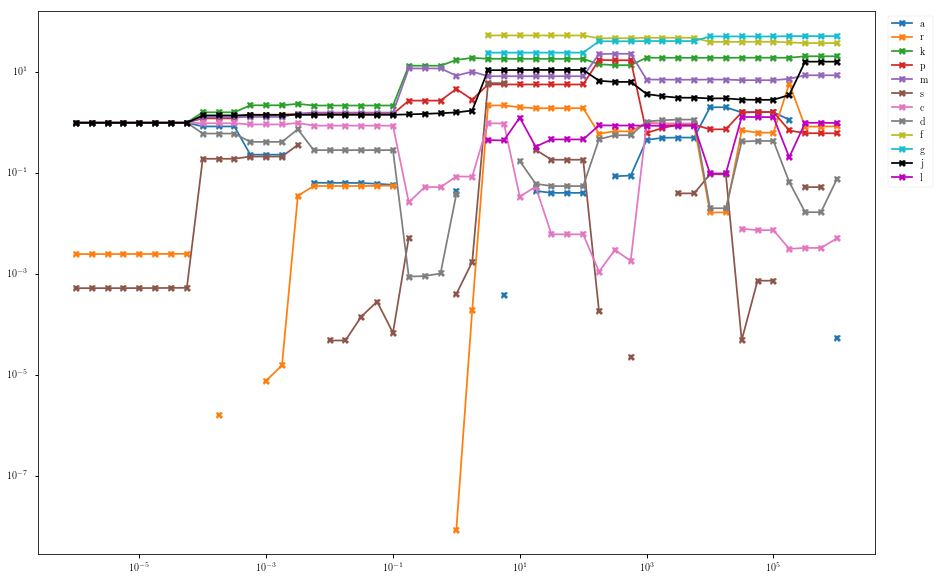

In [19]:
view.show_parameter_values(labels=plabels)

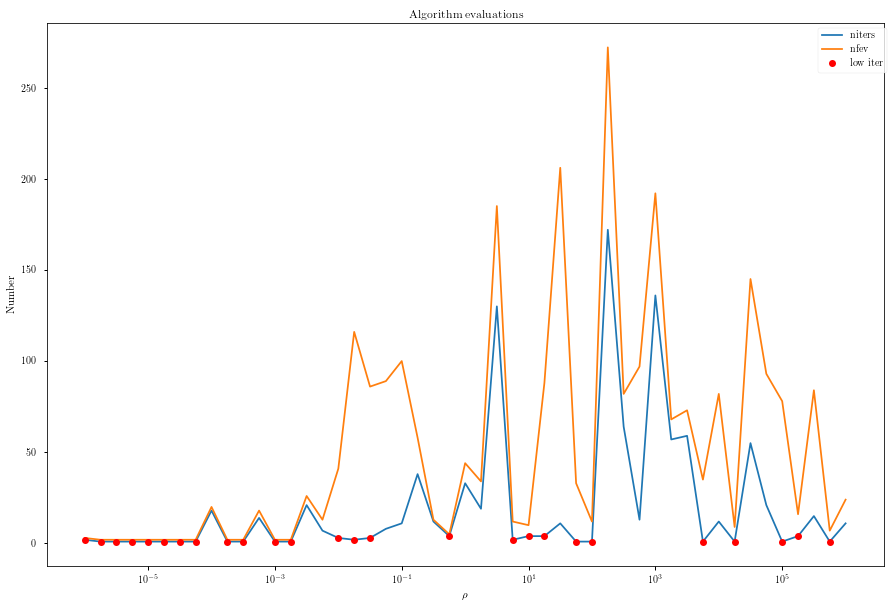

In [20]:
view.show_iterations()

In [29]:
rho = 3.1622776601683795

par a=0.0
par r=2.183396355562436
par k=18.288652231696044
par p=5.675413184080711
par m=8.256888646538679
par s=6.026077366447724
par c=0.9711342890751742
par d=0.0
par f=53.03967994204118
par g=24.155886570169702
par j=10.887439331736962
par l=0.44935018806288346


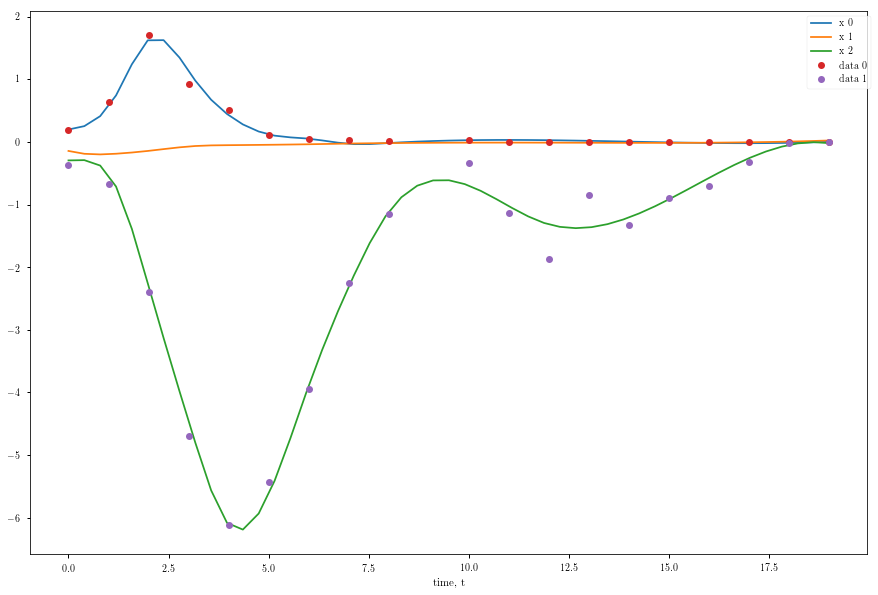

In [30]:
view.print_solution(rho, labels=plabels)
view.draw_solution(rho, plane='t')

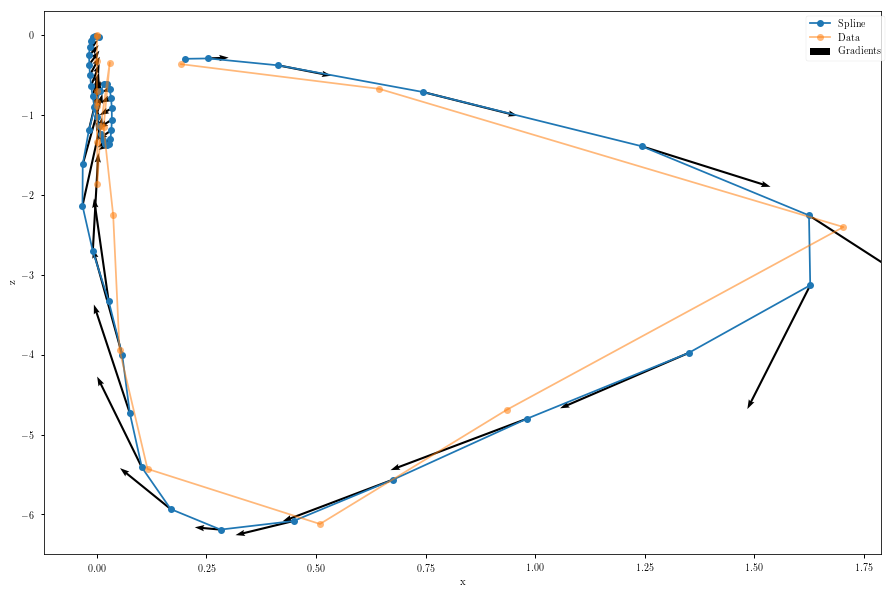

In [31]:
view.draw_solution(rho, plane=[0, 2], datakeys=['x', 'z'])

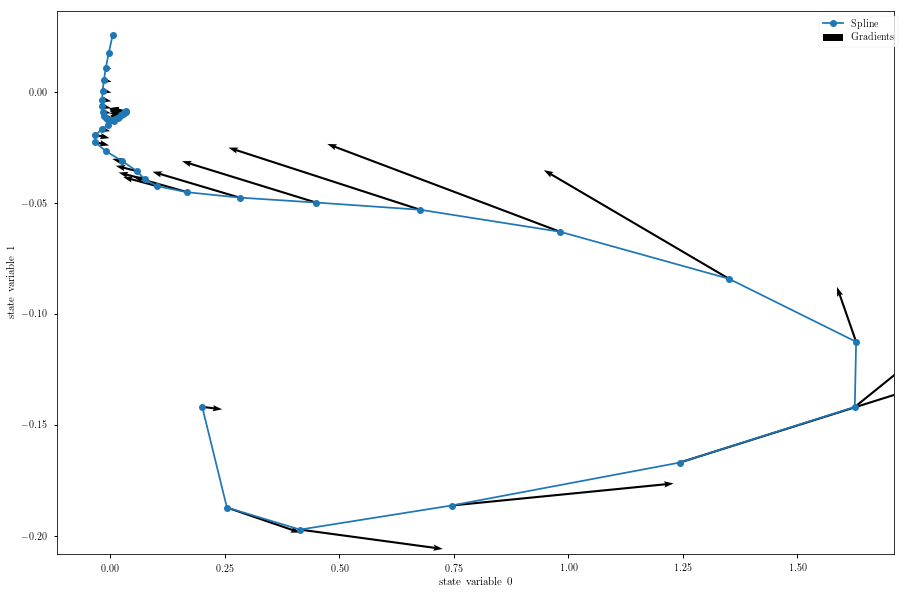

In [32]:
view.draw_solution(rho, plane=[0,1])

3.1622776601683795
 is the closest


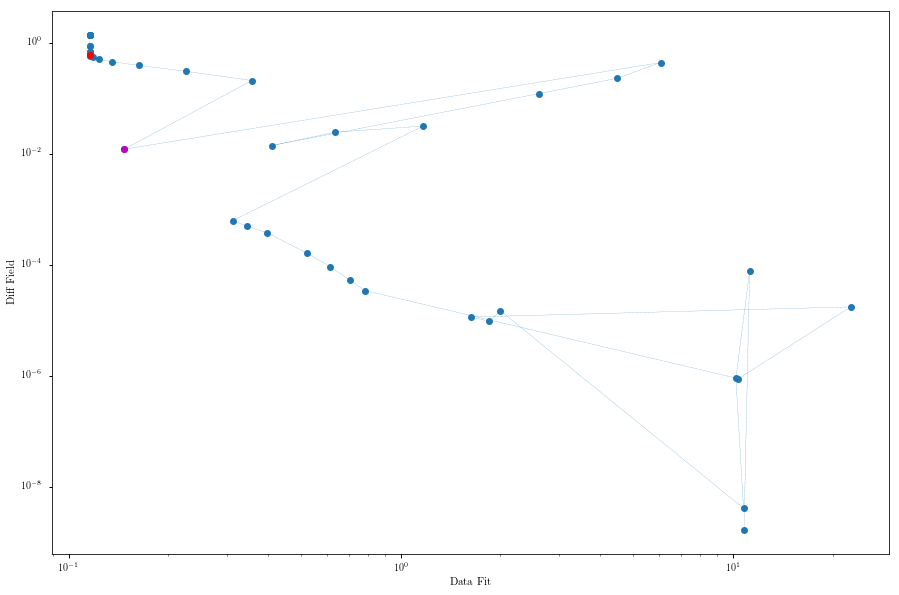

In [25]:
view.draw_lcurve(target_rho=rho, optimal=True)

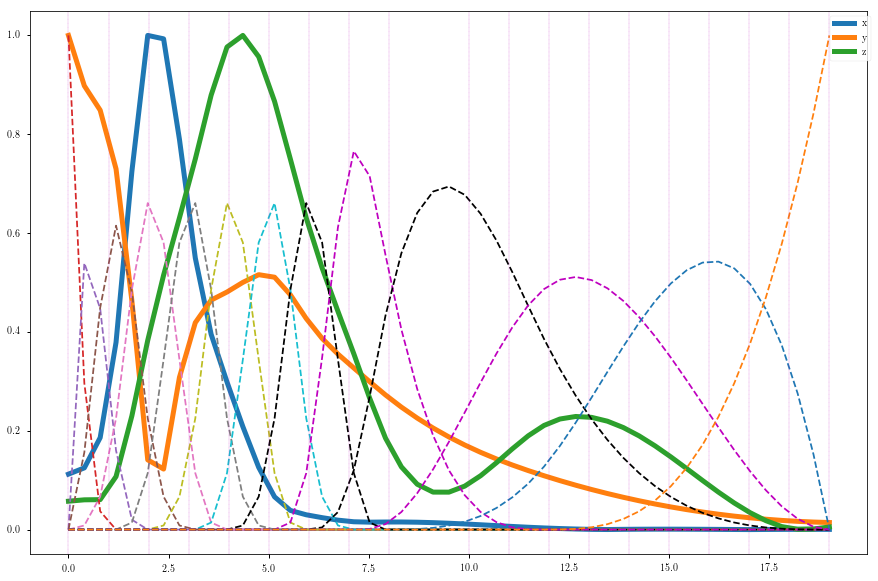

In [26]:
view.draw_basis(rho, labels='xyz')

[4.4036687875669916e-10, 2.9559801974495513e-05, 1.3912777793956967e-05, 6.351355605637225e-09, -2.657717416335671e-05, 19.92865201125213, 0.0, 57.19461106912627, 211.75688118410847, 1017.4894337477565, 2.9559801974495513e-05, 2853972.063652548]


/media/dwu402/Data/wrap-mad/viewer.py:243: RuntimeWarning: divide by zero encountered in true_divide
  ax.errorbar(pidx, ps_end, yerr=3*np.sqrt(1/np.array(fisher)), capsize=7,
/media/dwu402/Data/wrap-mad/viewer.py:243: RuntimeWarning: invalid value encountered in sqrt
  ax.errorbar(pidx, ps_end, yerr=3*np.sqrt(1/np.array(fisher)), capsize=7,


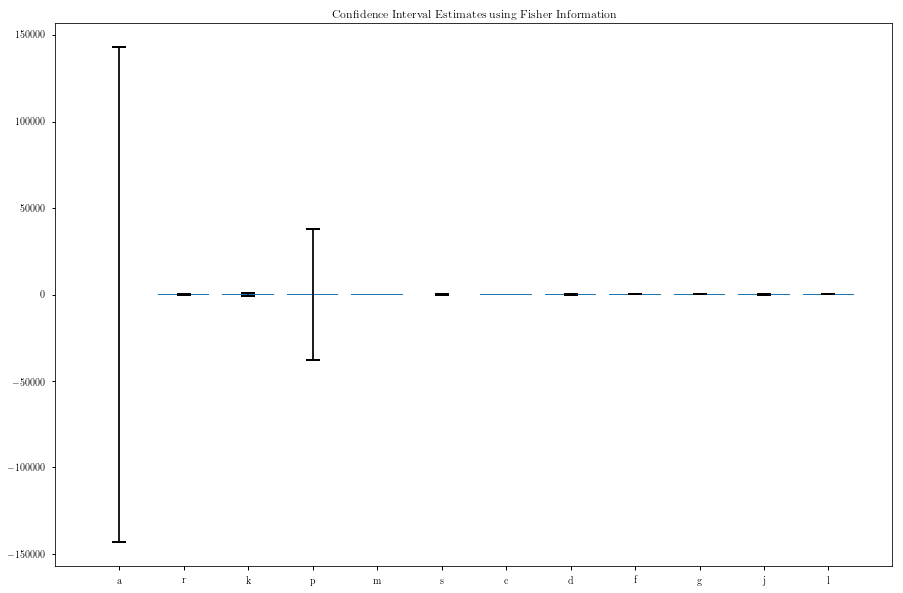

In [39]:
view.draw_confidence(1e1, labels=plabels, verbose=True)

In [28]:
list(map(str, rhos))

['1e-06',
 '1.778279410038923e-06',
 '3.162277660168379e-06',
 '5.623413251903491e-06',
 '1e-05',
 '1.778279410038923e-05',
 '3.1622776601683795e-05',
 '5.623413251903491e-05',
 '0.0001',
 '0.00017782794100389227',
 '0.00031622776601683794',
 '0.0005623413251903491',
 '0.001',
 '0.0017782794100389228',
 '0.0031622776601683794',
 '0.005623413251903491',
 '0.01',
 '0.01778279410038923',
 '0.03162277660168379',
 '0.05623413251903491',
 '0.1',
 '0.1778279410038923',
 '0.31622776601683794',
 '0.5623413251903491',
 '1.0',
 '1.7782794100389228',
 '3.1622776601683795',
 '5.623413251903491',
 '10.0',
 '17.78279410038923',
 '31.622776601683793',
 '56.23413251903491',
 '100.0',
 '177.82794100389228',
 '316.22776601683796',
 '562.341325190349',
 '1000.0',
 '1778.2794100389228',
 '3162.2776601683795',
 '5623.413251903491',
 '10000.0',
 '17782.794100389227',
 '31622.776601683792',
 '56234.13251903491',
 '100000.0',
 '177827.94100389228',
 '316227.7660168379',
 '562341.3251903491',
 '1000000.0']